# NYC Data Adventures, Vol. 1: Subway Delays

*Does the NYC subway suck? Yes. Is it getting worse over time? Let's look at the data!*

by Jeff Jacobs, jpj251@nyu.edu

At this point in NYC history pretty much everyone has conceded, *anecdotally*, that it's [one of the worst subway systems in the world](https://www.nytimes.com/2018/02/20/nyregion/mta-train-delays.html). However, we're data scientists, so let's explore exactly what this means and, in particular, what types of policies we would need to implement in order to fix it.

## Data Analysis: Where Do We Start?

Statistician John Tukey, back in the 70s, introduced a helpful (though potentially misleading) piece of terminology. **["Exploratory" data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis)**, as he called it, refers to a data science endeavor wherein the researcher has an intersting dataset but isn't sure what they will find within it. The idea is to counterpose the case where you're "exploring" a dataset, with the purpose of *generating* hypotheses, against the very different case of "confirmatory data analysis", where you *already have* a hypothesis and you are using the dataset to try and test it.

Schematically, we can represent the basic difference between the two cases as follows:

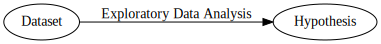

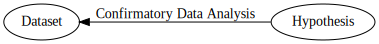

In [168]:
from graphviz import Digraph
explore = Digraph()
explore.attr(rankdir='LR')
explore.node('Dataset')
explore.node('Hypothesis')
explore.edge('Dataset','Hypothesis',label='Exploratory Data Analysis   ')
display(explore)

confirm = Digraph()
confirm.attr(rankdir='RL')
confirm.node('Dataset')
confirm.node('Hypothesis')
confirm.edge('Hypothesis','Dataset',label='Confirmatory Data Analysis')
display(confirm)

In reality, however, the two aren't really dichotomous. There is no such thing as a "purely" exploratory data analysis, since humans are *always* going to come to data/information with some (potentially very vague) preexisting notions of what they're looking for. And there is also no such thing as a "purely" confirmatory data analysis, since even in the best case scenario there are always [researcher degrees of freedom](https://en.wikipedia.org/wiki/Researcher_degrees_of_freedom) (see also the data-analytic ["garden of forking paths"](http://www.stat.columbia.edu/~gelman/research/unpublished/p_hacking.pdf)), meaning that at various decision points in our data analysis we're very subtly (well, sometimes [blatantly](https://www.youtube.com/watch?v=A0vEGuOMTyA&feature=youtu.be)) modifying the details of exactly *how* we're subjecting the dataset to (supposedly/theoretically "transparent") statistical tests.

So, with that said -- in the case of our subway data analysis project, which type of data analysis better describes what we are carrying out?

*Confirmatory* data analysis. We already have three hypotheses, which I list here alongside the type of dataset we would need in order to investigate them:

| Hypothesis Name | Hypothesis | Necessary Data |
|------|-------|---|
| **H1** | The NYC subway system is getting worse over time | A time-series dataset of overall NYC subway delay rates over time |
| **H2** | The NYC subway system is among the worst in the world | A cross-section of global subway *systems* along with their delay rates |
| **H3** | The NYC sybway system is even worse for poorer people | A cross-sectional dataset of NYC subway *lines* along with average income of their surrounding areas

and we are now seeking out these types of datasets, on which we can try to *test* these already-existing hypotheses.

Conversely, if someone had come to us saying "Hey, I found a bunch of cool NYC subway datasets" and we had no idea what we'd find in them, we'd be more on the *exploratory* data analysis side of the spectrum.

So, keeping all that in mind, let's dive into the first hypothesis **H1**!

## Finding the Dataset(s)

As illustrated in the Confirmatory Data Analysis diagram above, then, the next step is to find some datasets we can use to subject **H1** to some ["severe testing"](https://www.cambridge.org/core/books/statistical-inference-as-severe-testing/D9DF409EF568090F3F60407FF2B973B2).

Oftentimes in articles like this the author will act as if the datasets they end up using appeared out of thin air, thanks to some sort of dataset fairy who always pops in with the perfect dataset for the article's narrative. Here I'll avoid and demystify that: I googled "NYC subway datasets", along with several other related queries, and once I found an [interesting article with some potentially helpful data](https://www.citylab.com/transportation/2015/08/charting-the-new-york-subways-plunging-on-time-rate/401756/) from CityLab I then clicked through their sources (thankfully they're clearly cited within the article -- this won't always be the case, sadly) to find [a PDF from the NY State Comptroller's Office](https://www.osc.state.ny.us/audits/allaudits/093015/14s56.pdf) containing the data I wanted. Sadly, it only contains monthly subway delay data over a span of 13 months, but everything that I'm doing here should work just as well (in fact, should be even more interesting) with a longer-term dataset.

## Getting the Dataset(s) into a Usable Form

As you'll quickly and frustratingly find if you start working with "open" city data, however, the PDF format isn't exactly (at all) conducive to data analysis. As far as I know, data analysis programs/packages are not smart enough yet to let you toss a PDF file in and say "hey here's my data! It's on page 15! Let's go!" Instead, you'll need to get the data into a format that these programs/packages recognize. The most common (I'm tempted to call it the "industry standard" but... tbh I don't have a good enough sample across the entire industry) format for a "standard" row-column format dataset is the **comma-separated values** format, usually shortened to **.csv** as the file extension.

A quick note before we figure out the PDF $\rightarrow$ csv conversion, though: A good number of non-`.csv` formats, even proprietary formats such as Excel's `.xls`/`.xlsx` or Stata's `.dta`, are directly compatible with the Pandas data science library for Python (which we'll see in-depth below). Meaning, depending on your data, you may be able to instantly start working with it in Python by just calling (for example) Pandas' `read_excel()` or `read_stata()` functions.

In our case, though, Pandas does not have a built-in `read_pdf()` function. So instead we'll use what's called an Optical Character Recognition ("OCR") program, which scans a PDF and tries to extract its textual/numeric contents, though it's not always perfect (or even successful at all). There are free OCR programs available (notably, [Tesseract](https://github.com/tesseract-ocr/tesseract)), but I ended up using a sadly-not-free one called Abbyy FineReader, after extracting just the page containing the table I wanted (an important step if you're using a huge book and you don't want the program to waste time scanning through hundreds of extraneous pages) using the also sadly-not-free Adobe Acrobat Reader Pro, though for the latter task there are many equally-good free alternatives.

The result looks like:

![abbyy result](abbyy.png)

Where the program's attempt to read the numbers off the table is in the upper-right panel. Looks pretty good! I then exported this to Excel format, just to clean up some extraneous characters Abbyy mistakenly added below the table:

![Excel cleaning](excel.png)

## Loading the Dataset

With these characters removed, I saved the data in `.csv` format from within Excel to produce my first ready-to-analyze dataset, which I can now load into Pandas as follows:

In [144]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

delays_df = pd.read_csv("Monthly_Delays.csv")
display(delays_df)

,Categories,Mar-13,Apr-13,May-13,Jun-13,Jul-13,Aug-13,Sep-13,Oct-13,Nov-13,Dec-13,Jan-14,Feb-14,Mar-14,Total
0,Car Equipment,"1,527","1,967","1,222","1,729","1,381","1,899","2,409","2,735","2,457","2,020","2,095","2,578","3,638","27,657"
1,Collision/ Derailment,0,0,0,41,263,0,0,5,3,0,0,0,0,312
2,Employee,509,545,616,673,683,"1,059","1,095","1,248",785,746,481,731,882,"10,053"
3,External,5,18,9,117,37,472,274,338,297,323,266,316,190,"2,662"
4,Fire,334,817,763,564,"1,034",453,986,299,927,585,"1,224",936,864,"9,786"
5,Inclement Weather,537,"1,759",500,87,274,494,63,63,36,68,320,"2,156","7,020","13,377"
6,Infrastructure,408,"1,120",792,212,295,537,313,"1,115",263,397,85,590,"1,235","7,362"
7,Operational Divisions,269,240,267,299,406,306,304,262,363,443,630,757,905,"5,451"
8,Over Crowding,"5,050","5,759","5,023","5,029","5,090","5,384","5,892","5,823","6,374","7,225","7,419","7,883","8,665","80,616"
9,Police,"2,187","2,046","2,343","2,430","1,873","1,668","1,738","1,514","1,595","3,571","1,998","2,247","2,381","27,591"


## Doing the Data Science

Ok, let's start data science-ing! Here we're only interested in the *total* number of delays, so let's go ahead and make a smaller dataset `totals_df` containing only the totals for each month. Note that we apply the `copy()` function at the end, to ensure that `totals_df` is a completely separate DataFrame from `delays_df` (as opposed to an internal "slice" of `delays_df`, with modifications affecting the latter)

In [146]:
totals_df = delays_df[delays_df["Categories"] == "Total"].copy()
display(totals_df)

,Categories,Mar-13,Apr-13,May-13,Jun-13,Jul-13,Aug-13,Sep-13,Oct-13,Nov-13,Dec-13,Jan-14,Feb-14,Mar-14,Total
15,Total,"31,470","33,658","31,593","30,261","34,823","36,507","40,048","39,063","39,003","41,525","40,974","44,251","55,713","498,889"


We also don't care about the sum total across all months, since we only want to see how it *changes* over time, so we'll also drop the final "Totals" column on the right. Similarly, we already know that the one row represents the total of all categories, so we'll drop the now-useless "Categories" column. This time, rather than making a whole new dataset, we'll simply perform the drops *in place*, meaning that the existing variable `totals_df` itself is affected (whereas before `delays_df` was *not* modified since we created a new variable `totals_df` to hold just the totals row).

In [147]:
totals_df.drop(columns=['Categories','Total'] ,inplace=True)

In [148]:
display(totals_df)

,Mar-13,Apr-13,May-13,Jun-13,Jul-13,Aug-13,Sep-13,Oct-13,Nov-13,Dec-13,Jan-14,Feb-14,Mar-14
15,"31,470","33,658","31,593","30,261","34,823","36,507","40,048","39,063","39,003","41,525","40,974","44,251","55,713"


We've almost constructed our time-series dataset of subway delays, but remember that in any dataset the *rows* should represent an observation (in the case of time-series data, a particular point in time) while the *columns* should represent properties of that observation (in this case, the number of delays for that month).

In [149]:
month_df = totals_df.melt(var_name='month', value_name='num_delays')
month_df

,month,num_delays
0,Mar-13,"31,470"
1,Apr-13,"33,658"
2,May-13,"31,593"
3,Jun-13,"30,261"
4,Jul-13,"34,823"
5,Aug-13,"36,507"
6,Sep-13,"40,048"
7,Oct-13,"39,063"
8,Nov-13,"39,003"
9,Dec-13,"41,525"


Cool. Now, see how the `num_delays` column's values have commas in them? That's a bad sign, which means that Pandas probably isn't interpreting these values as *numbers*, but as *strings* (since numbers in Python's internal data representation don't have commas in them). So, we'll get rid of the commas using Python's built-in string function `replace(",","")` (note that we have to use `<column>.str` rather than just `<column>` on its own if we want to use the built-in string functions on *each cell* within the column simultaneously) and then use the `pd.to_numeric()` function to convert this column:

In [150]:
month_df["num_delays"] = pd.to_numeric(month_df["num_delays"].str.replace(",",""))
month_df

,month,num_delays
0,Mar-13,31470
1,Apr-13,33658
2,May-13,31593
3,Jun-13,30261
4,Jul-13,34823
5,Aug-13,36507
6,Sep-13,40048
7,Oct-13,39063
8,Nov-13,39003
9,Dec-13,41525


Now we'll use Pandas' `to_datetime()` function -- importantly including a [datetime format code](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes) so it knows exactly what "Mar-13", "Apr-13", and so on are referring to -- so it can recognize and represent the data internally as time-series data.

In [151]:
month_df["month"] = pd.to_datetime(month_df["month"], format='%b-%y')
month_df.set_index("month", inplace=True)
month_df

,num_delays
month,
2013-03-01,31470
2013-04-01,33658
2013-05-01,31593
2013-06-01,30261
2013-07-01,34823
2013-08-01,36507
2013-09-01,40048
2013-10-01,39063
2013-11-01,39003


## Visualizing / Iterating our Visualizations of the Data

Now that Pandas is fully on the same page as us, in terms of knowing to interpret the index variable "month" as a date variable, we can make some extremely simple visualizations using Pandas' `plot()` function which will automatically format and label the time axis!

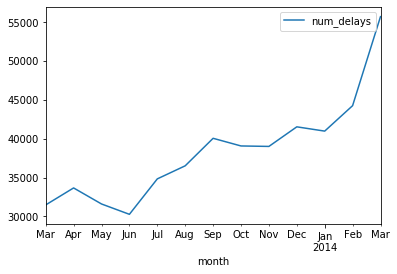

In [153]:
month_df.plot()

Welp, to me this visualization seems like it supports our hypothesis **H1** pretty well. However, this is an observation containing a huge amount of interpretation.

For example, what do we consider to be a high or low number of delays? This brings up a classic data-interpretation lesson, namely, what would the visualization look like if plotted with the $y$ axis starting at *zero* rather than 30,000? Let's take a look:

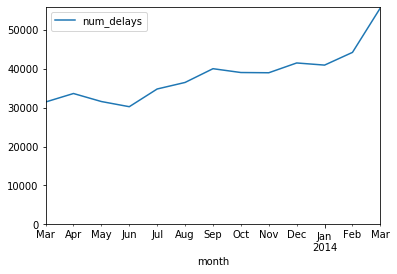

In [154]:
month_df.plot(ylim=(0,56000))

This still looks bad to me, but visually we now can see that the trend *started* from an already fairly-high number of delays (again, total subjective-interpretation until we can get a sense of the distribution of subway delays across systems).

Next, we have to consider: when reading this plot, are we comparing to a pre-existing expectation that the number of delays on a subway should remain about the same over time? Perhaps with spikes only during periods of inclement weather? In this case, although fancier methods would be more helpful, for now we'll just drop months with "cold" weather. Since there are only 12 months total, I can quickly "drop in" mean temperature data from the [New York City Wikipedia article](https://en.wikipedia.org/wiki/New_York_City#Climate) using a Python dictionary:

In [155]:
avg_temps = {'January':32.6, 'February':35.3, 'March': 42.5, 'April': 53.0, 'May': 62.4,
             'June': 71.5, 'July': 76.5, 'August': 75.2, 'September': 68.0, 'October': 56.9,
             'November': 47.7, 'December': 37.5}

(Here noting that the `lambda x: f(x)` format just means "for each x in the index, do `f(x)` to it, and that `month_name()` is a function built into Pandas' `Timestamp` class)

In [157]:
month_df["avg_temp"] = month_df.index.map(lambda x: avg_temps[x.month_name()])

In [158]:
month_df

,num_delays,avg_temp
month,,
2013-03-01,31470,42.5
2013-04-01,33658,53.0
2013-05-01,31593,62.4
2013-06-01,30261,71.5
2013-07-01,34823,76.5
2013-08-01,36507,75.2
2013-09-01,40048,68.0
2013-10-01,39063,56.9
2013-11-01,39003,47.7


And now I can generate the same plot as before but *without* all months where the daily mean temperature drops below 40°F:

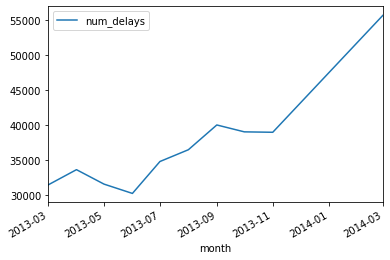

In [159]:
month_df[month_df['avg_temp'] >= 40.0].plot(y="num_delays")

Hm. Still bad to me, but that temperature threshold was arbitrary. We could have instead used 50°F as our coldness-threshold:

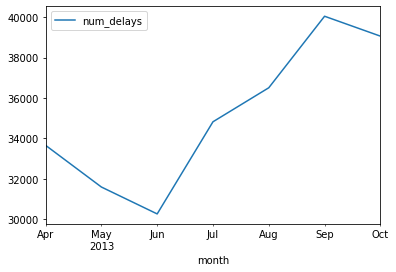

In [160]:
month_df[month_df['avg_temp'] >= 50.0].plot(y='num_delays')

If we squinted enough at this, we could even lie with data by making up a totally new narrative! Like *''The subway gets worse and worse from June to September, but then gets better from September to June, in a big beautiful subway circle-of-life."* We would have to explain or wave our hands rapidly over why November, December, January, February, and March are totally absent from this plot, and why we only have data for one year (something we'd need to address in all our prior stories as well!), but hey, persuasion is persuasion.

## What Are We Comparing Against?

Personally, my "background model" for what this plot should look like is one in which the number of delays should *decrease* every month, due to improvements in technology being implemented by a robust democratically-responsive city government! So, let's make a new hypothetical time series indicating what the plot would look like if the number of delays decreased by 10% each month:

In [139]:
model_delays = [month_df["num_delays"].iloc[0] * (0.9**i) for i in range(13)]
month_df["num_delays_model"] = model_delays
month_df

,num_delays,avg_temp,month_name,num_delays_model
month,,,,
2013-03-01,31470,42.5,March,31470.000000
2013-04-01,33658,53.0,April,28323.000000
2013-05-01,31593,62.4,May,25490.700000
2013-06-01,30261,71.5,June,22941.630000
2013-07-01,34823,76.5,July,20647.467000
2013-08-01,36507,75.2,August,18582.720300
2013-09-01,40048,68.0,September,16724.448270
2013-10-01,39063,56.9,October,15052.003443
2013-11-01,39003,47.7,November,13546.803099


and now let's compare this 10%-better-each-month trend with our real-world trend:

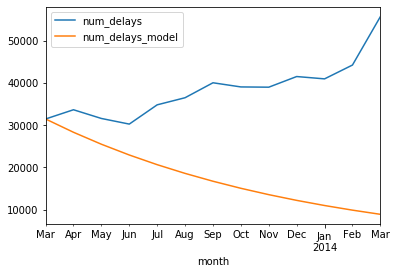

In [140]:
month_df.plot(y=['num_delays','num_delays_model'])

To really drive the point home, let's produce one final variable indicating how much worse the real-world subway data is than our expectations from our model:

In [141]:
month_df["how_much_worse"] = month_df['num_delays'] - month_df['num_delays_model']

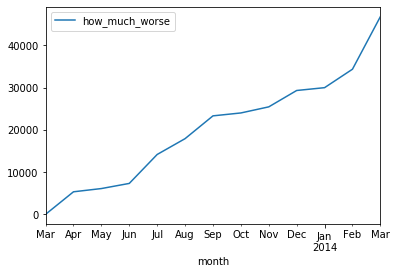

In [142]:
month_df.plot(y='how_much_worse')

And thus we can see a world of ever-increasing badness relative to a hypothetical world where we see the subway getting better and better due to gradual improvements in technology. (So much interpretation going on here, but your mind should be attuned to this by now!)

## Conclusion

Hopefully throughout this lesson, but *especially* in the later sections, you observed how I was making more and more assumptions the more I "dug into" the data. This is what I meant at the beginning by "researcher degrees of freedom", and why you should be all the more skeptical of findings/intepretations from data science projects that took far longer and are far more complex than this one.

Notice how I left those next two hypotheses, **H2** and **H3**, dangling up there? We'll explore them in the next installation. But you've now gotten your feet wet with what it looks like to find and analyze time-series data!